In [1]:
import json
import torch
import datasets
import requests
import evaluate
import numpy as np
import huggingface_hub
from PIL import Image
import albumentations as A
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, Any
from dataclasses import dataclass
from datasets import load_dataset
import matplotlib.patches as mpatches
from huggingface_hub import hf_hub_download
from torch.utils.data import Dataset, DataLoader
from transformers import (
    MaskFormerImageProcessor,
    AutoImageProcessor,
    MaskFormerForInstanceSegmentation,
)

torch.manual_seed(42)


import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import matplotlib.pyplot as plt
import random

from transformers import TrainingArguments, Trainer
from transformers import MaskFormerForInstanceSegmentation, MaskFormerConfig
from transformers import AutoImageProcessor

c:\Users\comi\AppData\Local\anaconda3\envs\woundseg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\comi\AppData\Local\anaconda3\envs\woundseg\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
image_dir = r'C:/users/comi/Desktop/Wound_segmentation_III/Data/new_images_640_1280'
mask_dir = r'C:/users/comi/Desktop/Wound_segmentation_III/Data/new_masks_640_1280'

image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

# Ensure image and mask names correspond
image_filenames.sort()
mask_filenames.sort()


In [3]:
def load_images_and_masks(image_dir, mask_dir, image_filenames, mask_filenames):
    images = []
    masks = []
    instance_class_mapping = []

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        # Load image and mask
        img = Image.open(os.path.join(image_dir, img_file))
        mask = Image.open(os.path.join(mask_dir, mask_file))
        
        # Convert to numpy arrays
        img = np.array(img)
        mask = np.array(mask)
        
        # Extract class labels from the mask (assuming the class is encoded as wound_class * 15)
        mask_class = mask // 15  # This extracts the class label for each pixel

        # Create an instance mask (simply for this example, assuming each unique value is an instance)
        # This may be provided by your dataset if you have instance IDs
        instance_ids = mask  # Use the raw mask values as instance IDs (assuming each unique value is an instance)

        # Find all unique instance IDs (ignoring background class 0)
        unique_instance_ids = np.unique(instance_ids[instance_ids != 0])

        # Create a dictionary mapping each instance ID to its class
        class_mapping = {}
        for instance_id in unique_instance_ids:
            # Map the instance ID to the class by taking the first pixel of that instance
            class_mapping[instance_id] = mask_class[mask == instance_id][0]

        # Append the results
        images.append(img)
        masks.append(mask_class)  # Use the class-based mask
        instance_class_mapping.append(class_mapping)  # Map instance IDs to their classes
    
    return np.array(images), np.array(masks), instance_class_mapping  # Return the mappings too

# Example usage:
images, masks, instance_class_mapping = load_images_and_masks(image_dir, mask_dir, image_filenames, mask_filenames)


In [4]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val, mapping_train, mapping_val = train_test_split(
    images, masks, instance_class_mapping, test_size=0.2, random_state=42
)

# Output the number of training and validation images
print(f"Training images: {len(X_train)}, Validation images: {len(X_val)}")
print(f"Instance-Class Mapping for the first training image: {mapping_train[0]}")


Training images: 1600, Validation images: 401
Instance-Class Mapping for the first training image: {15: 1}


{15: 1, 30: 2, 90: 6, 150: 10}


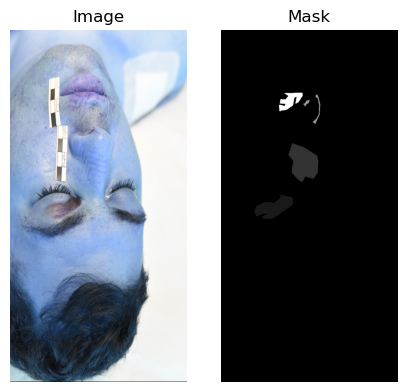

In [30]:
def visualize_image_with_label(images, masks, mappings):
    # Pick a random index
    idx = random.randint(0, len(images) - 1)
    
    # Extract the corresponding image and mask
    img = images[idx]
    mask = masks[idx]
    mapping = mappings[idx]
    
    # Plot the image and its mask side by side
    plt.figure(figsize=(5, 5))
    
    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Image')
    plt.axis('off')
    
    # Display the corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    print(mapping)
    plt.show()

# Call the function to visualize a random image and its label
visualize_image_with_label(X_train, y_train, mapping_train)


In [31]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert to NumPy arrays if necessary
        if isinstance(image, Image.Image):
            image = np.array(image)
        if isinstance(mask, Image.Image):
            mask = np.array(mask)

        # Apply any transformations (optional)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Convert the images and masks to tensors
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # HWC -> CHW
        mask_tensor = torch.tensor(mask, dtype=torch.long)  # Masks should be long type for labels

        return {
            "pixel_values": image_tensor,  # Input image
            "class_labels": mask_tensor   # Segmentation mask
        }


In [32]:
class CustomSegmentationTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract pixel_values and labels from the inputs
        pixel_values = inputs["pixel_values"]
        
        # Use torch.stack to batch the labels (masks)
        labels = torch.stack([f["class_labels"] for f in inputs["class_labels"]])  # Batch labels

        # Forward pass through the model
        outputs = model(pixel_values=pixel_values)

        # Get the mask logits from the output (adjust based on your actual output structure)
        masks_queries_logits = outputs.masks_queries_logits  # Example: (batch_size, num_queries, height, width)

        # Reshape logits for cross-entropy loss
        masks_queries_logits = masks_queries_logits.permute(0, 2, 3, 1).contiguous()  # Move num_queries to last dim
        masks_queries_logits = masks_queries_logits.view(-1, masks_queries_logits.size(-1))  # Flatten logits
        
        # Flatten labels to match logits
        labels = labels.view(-1)  # Flatten labels for cross-entropy loss

        # Compute pixel-wise cross-entropy loss
        loss = F.cross_entropy(masks_queries_logits, labels)

        return (loss, outputs) if return_outputs else loss


In [33]:
processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco", return_dict = True)

c:\Users\comi\AppData\Local\anaconda3\envs\woundseg\Lib\site-packages\transformers\utils\deprecation.py:165: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)


In [34]:
train_dataset = SegmentationDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Validation set (if you have one)
val_dataset = SegmentationDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [35]:
# Example: Get a batch from the dataloader
batch = next(iter(train_loader))
print(batch['pixel_values'].shape)  # Should be (batch_size, 3, height, width)
print(batch['class_labels'].shape)  # Should be (batch_size, height, width)


torch.Size([4, 3, 1280, 640])
torch.Size([4, 1280, 640])


In [45]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="./maskformer_output",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="steps",
    save_steps=500,
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=5e-5,
)


In [37]:
outputs = model(pixel_values=batch['pixel_values'], class_labels = batch["class_labels"])


In [38]:
print(outputs.keys())  # Should be (batch_size, num_queries, height, width)
print(outputs.masks_queries_logits.shape)  # Should be (batch_size, num_queries, height, width)


odict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])
torch.Size([4, 100, 320, 160])


In [42]:
class DataCollatorForSegmentation:
    def __call__(self, features):
        # Stack the pixel_values (images) from the features
        pixel_values = torch.stack([feature["pixel_values"] for feature in features])
        
        # Stack the labels (masks) from the features
        labels = torch.stack([feature["class_labels"] for feature in features])
        
        # Return as dictionary to be fed into the model
        return {
            "pixel_values": pixel_values,
            "class_labels": labels  # Keep the labels as full 2D masks
        }

# Instantiate the custom data collator
data_collator = DataCollatorForSegmentation()


In [25]:
class CustomSegmentationTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract pixel_values and class_labels from inputs
        pixel_values = inputs["pixel_values"]
        class_labels = inputs["class_labels"]  # Now using 'class_labels' for the segmentation masks
        
        # Forward pass through the model
        outputs = model(pixel_values=pixel_values, class_labels=class_labels)  # Use 'class_labels'
        
        # Access the loss from outputs (MaskFormer should compute it)
        loss = outputs["loss"] if "loss" in outputs else None
        
        # If loss is missing, handle accordingly
        if loss is None:
            raise ValueError("The model did not return a loss. Check the input structure.")

        return (loss, outputs) if return_outputs else loss


In [46]:

# Instantiate the trainer
trainer = CustomSegmentationTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator  # Use the custom data collator here
)

# Train the model
trainer.train()


  0%|          | 0/2000 [23:45<?, ?it/s]


IndexError: too many indices for tensor of dimension 2

In [44]:
# Define the custom trainer
trainer = CustomSegmentationTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Ensure your train_dataset returns both pixel_values and labels
    eval_dataset=val_dataset,    # Ensure your eval_dataset does the same
)

# Start training
trainer.train()


  0%|          | 0/2000 [00:00<?, ?it/s]

IndexError: too many indices for tensor of dimension 2

In [93]:
# Quick check on dataset
sample = train_dataset[0]
print(sample.keys())  # Should print: 'pixel_values', 'labels'
print(sample['text'].shape)  # Should be (C, H, W)
print(sample['label'].shape)  # Should be (H, W)


dict_keys(['text', 'label'])
torch.Size([3, 1280, 640])
torch.Size([1280, 640])


In [94]:
from transformers import TrainingArguments, Trainer

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./maskformer_output",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="steps",
    save_steps=500,
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=5e-5,
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # Ensure train_dataset returns both pixel_values and labels
    eval_dataset=val_dataset,      # Ensure eval_dataset does the same
)

# Start training
trainer.train()


  0%|          | 0/2000 [00:00<?, ?it/s]

RuntimeError: a Tensor with 819200 elements cannot be converted to Scalar